In [1]:
import sys
sys.path.append('../src')

import typing as tp
from copy import copy

import numpy as np
import matplotlib.pyplot as plt
import torch
from omegaconf import OmegaConf

from imutils import impreprocess, gray2gray3d, make_noised, load_npy
from data.convolution import convolve
from deconv.classic.wiener.wiener import wiener_gray
from deconv.neural.usrnet.predictor import USRNetPredictor
from deconv.neural.dwdn.predictor import DWDNPredictor
from deconv.neural.kerunc.predictor import KerUncPredictor
from services.psf_distorter import PSFDistorter
from metrics import psnr, ssim

plt.gray()

np.random.seed(8)

<Figure size 640x480 with 0 Axes>

In [2]:
def viz(
    image: np.ndarray,
    true_psf: np.ndarray,
    distorted_psf: np.ndarray,
    blurred: np.ndarray,
    blurred_3d: np.ndarray,
    models: dict,
    is_noised: bool,
):
    blurred_with_distorted_psf = convolve(image, distorted_psf)

    _, ax = plt.subplots(3, 4, figsize=(12, 10))

    ax[0, 0].imshow(true_psf)
    ax[0, 0].axis('off')
    ax[0, 0].set_title('True PSF')

    ax[0, 1].imshow(distorted_psf)
    ax[0, 1].axis('off')
    ax[0, 1].set_title(f'Distorted PSF (SSIM: {ssim(blurred, blurred_with_distorted_psf):.2f})')

    ax[0, 2].imshow(blurred)
    ax[0, 2].axis('off')
    ax[0, 2].set_title('Blurred')

    ax[0, 3].imshow(image)
    ax[0, 3].axis('off')
    ax[0, 3].set_title(f'Original image')

    noise = 'noise' if is_noised else 'no_noise'
    for i, model_name in enumerate(models.keys()):
        model = models[model_name][noise]
        
        restored = (
            model(blurred_3d, true_psf)[..., 0]
            if model_name in ['usrnet', 'dwdn']
            else model(blurred, true_psf)
        )
        ax[1, i].imshow(restored)
        ax[1, i].axis('off')
        ax[1, i].set_title(f'{model_name}\nssim: {ssim(image, restored):.2f}, psnr: {psnr(image, restored):.2f}')
    
        restored = (
            model(blurred_3d, distorted_psf)[..., 0]
            if model_name in ['usrnet', 'dwdn']
            else model(blurred, distorted_psf)
        )
        ax[2, i].imshow(restored)
        ax[2, i].axis('off')
        ax[2, i].set_title(f'{model_name}\nssim: {ssim(image, restored):.2f}, psnr: {psnr(image, restored):.2f}')

 
####

def get_image_psf(
    image_path: str,
    psf_path: str,
    crop: bool,
    is_noised: bool,
) -> tp.Tuple[np.array, np.array, np.array, np.array]:
    """Returns GRAY image in specified discretization"""

    image = impreprocess(image_path, crop=crop)
    psf = load_npy(psf_path, key='psf')

    mu = 0
    sigma = 0.01

    # blurred
    blurred = convolve(image, psf)
    blurred_3d = gray2gray3d(blurred)

    if is_noised:
        blurred = make_noised(blurred, mu=mu, sigma=sigma)
        blurred_3d = make_noised(blurred_3d, mu=mu, sigma=sigma)
    
    return image, psf, blurred, blurred_3d

In [3]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [4]:
config = OmegaConf.load('../configs/config_viz.yml')
cm = config.models

models = dict()

models['wiener'] = dict()
models['wiener']['noise'] = lambda image, psf: wiener_gray(image, psf, **cm.wiener_nonblind_noise.noise_params)
models['wiener']['no_noise'] = lambda image, psf: wiener_gray(image, psf, **cm.wiener_nonblind_noise.no_noise_params)

models['kerunc'] = dict()
models['kerunc']['noise'] = KerUncPredictor(**cm.kerunc.noise_params)
models['kerunc']['no_noise'] = KerUncPredictor(**cm.kerunc.no_noise_params)

models['usrnet'] = dict()
models['usrnet']['noise'] = USRNetPredictor(model_path=cm.usrnet.model_path, **cm.usrnet.noise_params)
models['usrnet']['no_noise'] = USRNetPredictor(model_path=cm.usrnet.model_path, **cm.usrnet.no_noise_params)

models['dwdn'] = dict()
models['dwdn']['noise'] = DWDNPredictor(model_path=cm.dwdn.model_path, **cm.dwdn.noise_params)
models['dwdn']['no_noise'] = DWDNPredictor(model_path=cm.dwdn.model_path, **cm.dwdn.no_noise_params)


In [5]:
distorter = PSFDistorter()

## 1 Motion blur

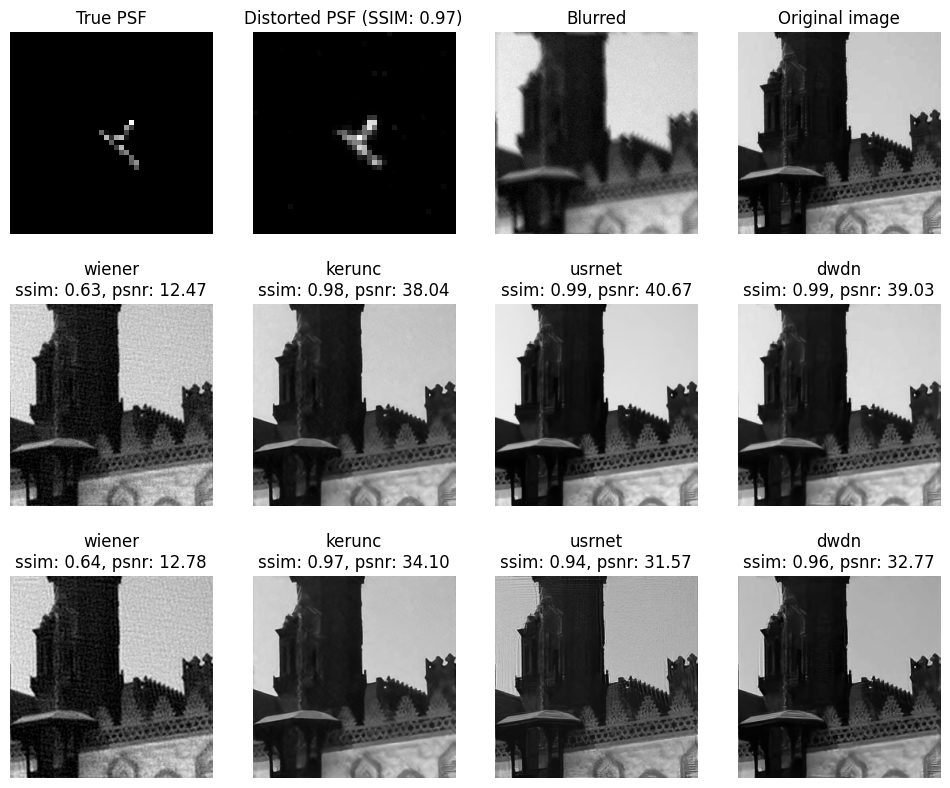

In [6]:
IS_NOISED = True

image, psf, blurred, blurred_3d = get_image_psf(
    image_path='../datasets/gt/Sun-gray/im_48.png',
    psf_path='../datasets/kernels/motion-blur/processed/synthetic/synthetic-29.npy',
    is_noised=IS_NOISED,
    crop=True,
)

psf_distorted = distorter('motion', ker=psf, v_g=0.01, gaus_var=0.8)

viz(image, psf, psf_distorted, blurred, blurred_3d, models, is_noised=IS_NOISED)

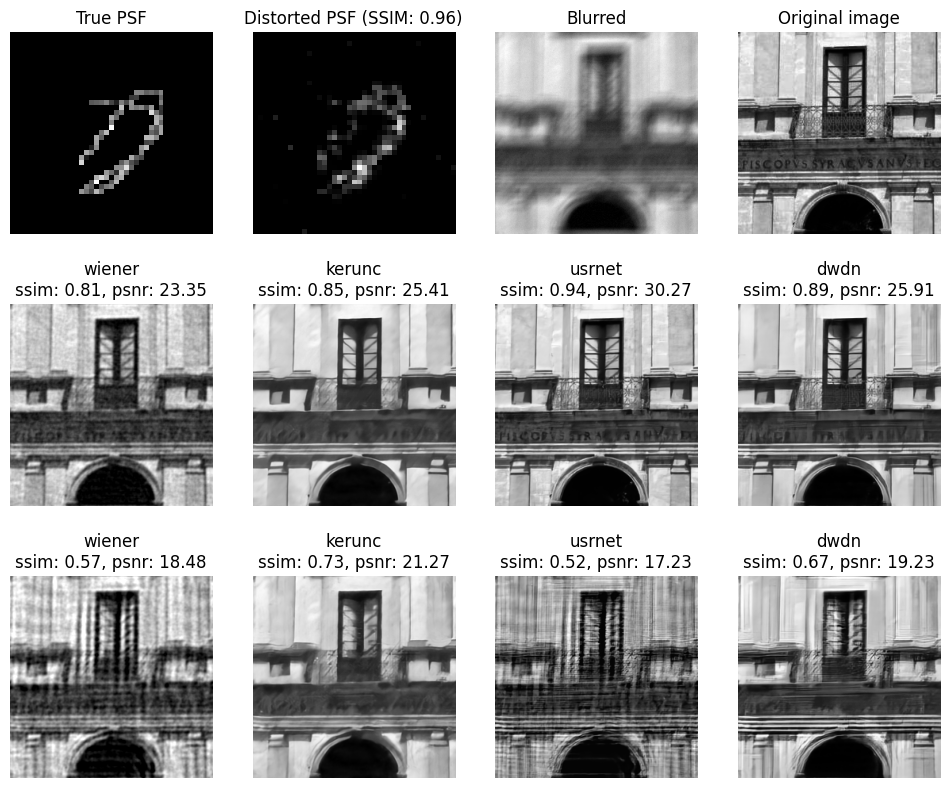

In [14]:
IS_NOISED = True

image, psf, blurred, blurred_3d = get_image_psf(
    image_path='../datasets/gt/Sun-gray/im_10.png',
    psf_path='../datasets/kernels/motion-blur/processed/synthetic/synthetic-26.npy',
    is_noised=IS_NOISED,
    crop=True,
)

psf_distorted = distorter('motion', ker=psf, v_g=0.01, gaus_var=0.8)


viz(image, psf, psf_distorted, blurred, blurred_3d, models, is_noised=IS_NOISED)

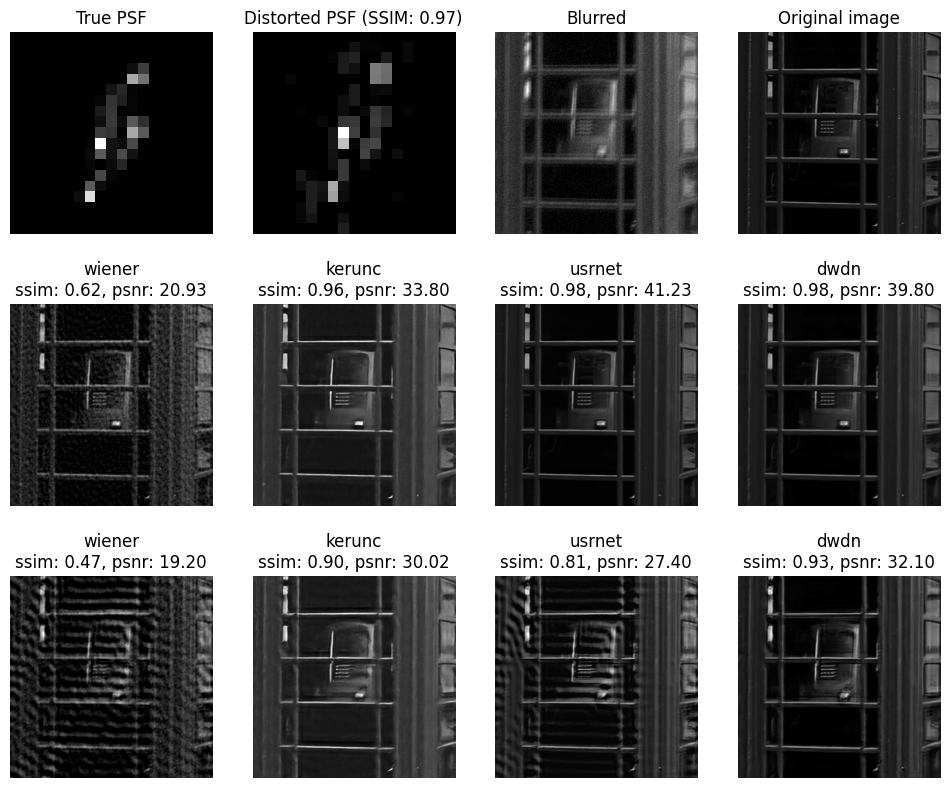

In [15]:
IS_NOISED = True

image, psf, blurred, blurred_3d = get_image_psf(
    image_path='../datasets/gt/Sun-gray/im_53.png',
    psf_path='../datasets/kernels/motion-blur/processed/Levin/levin-0.npy',
    is_noised=IS_NOISED,
    crop=True,
)

psf_distorted = distorter('motion', ker=psf, v_g=0.01, gaus_var=0.8)

viz(image, psf, psf_distorted, blurred, blurred_3d, models, is_noised=IS_NOISED)

## 2 Gauss blur

Old params: {'sigmax': 5, 'sigmay': 6, 'size': 4, 'angle': -130}
New params: {'sigmax': 5, 'sigmay': 7, 'size': 4, 'angle': -135}


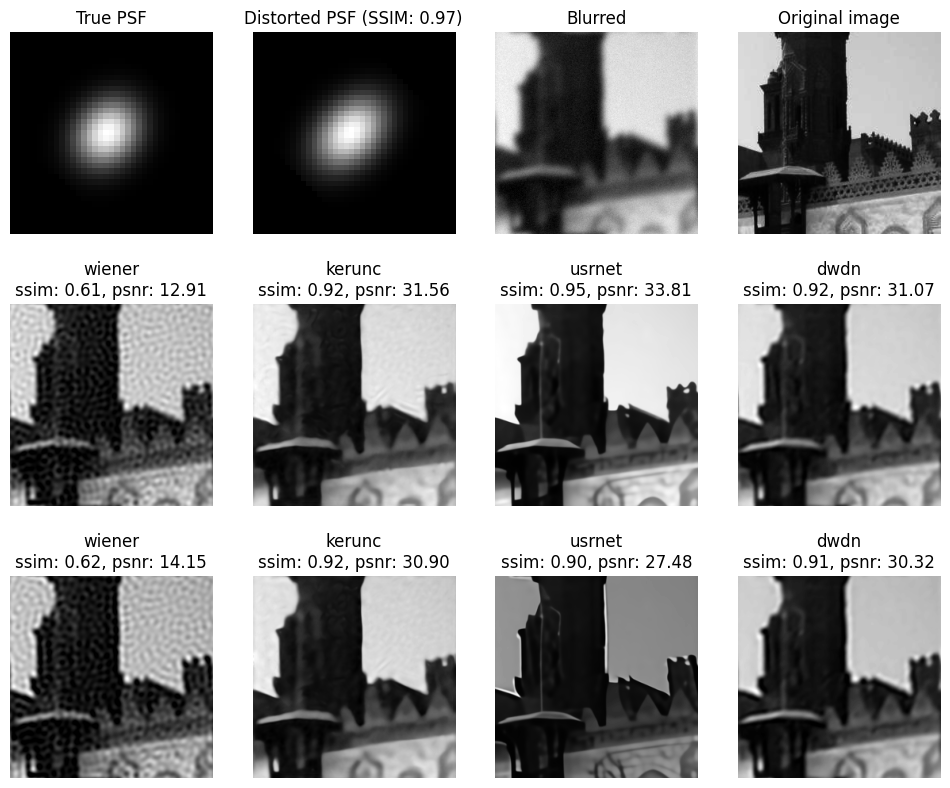

In [9]:
IS_NOISED = True
PSF_PATH = '../datasets/kernels/gauss-blur/processed/synthetic/synthetic-0.npy'

image, psf, blurred, blurred_3d = get_image_psf(
    image_path='../datasets/gt/Sun-gray/im_48.png',
    psf_path=PSF_PATH,
    is_noised=IS_NOISED,
    crop=True,
)

psf_distorted = distorter('gauss', psf_params=load_npy(PSF_PATH, key='params'), max_delta_sigma=2, max_delta_angle=10)

viz(image, psf, psf_distorted, blurred, blurred_3d, models, is_noised=IS_NOISED)

Old params: {'sigmax': 6, 'sigmay': 3, 'size': 6, 'angle': -80}
New params: {'sigmax': 5, 'sigmay': 1, 'size': 5, 'angle': -85}


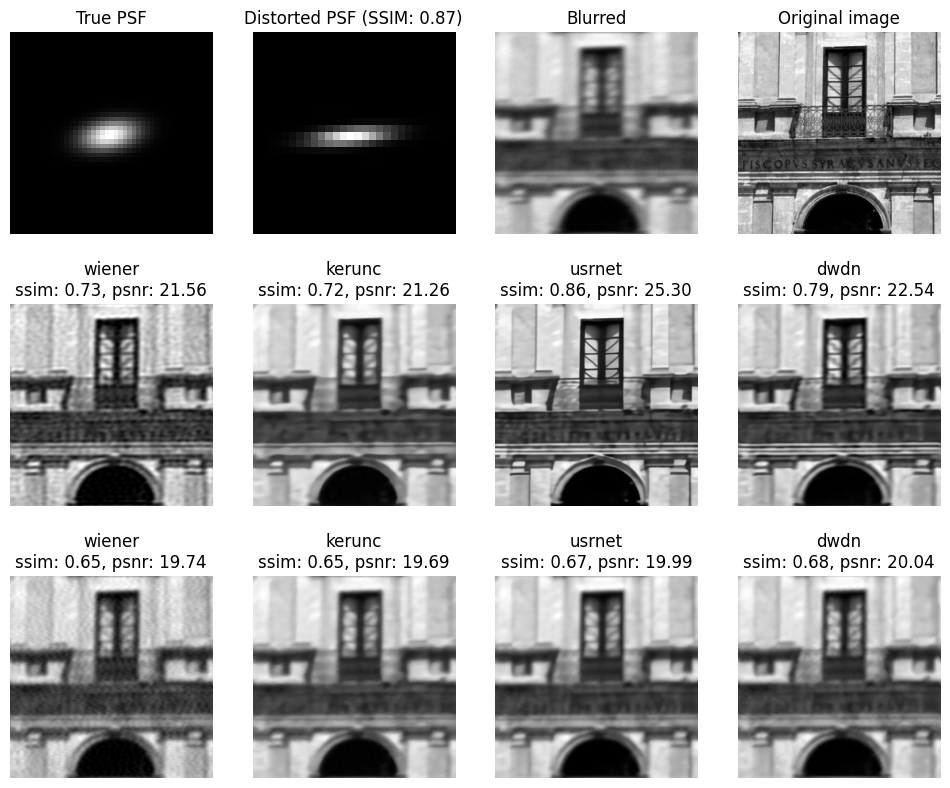

In [10]:
IS_NOISED = True
PSF_PATH = '../datasets/kernels/gauss-blur/processed/synthetic/synthetic-2.npy'

image, psf, blurred, blurred_3d = get_image_psf(
    image_path='../datasets/gt/Sun-gray/im_10.png',
    psf_path=PSF_PATH,
    is_noised=IS_NOISED,
    crop=True,
)

psf_distorted = distorter('gauss', psf_params=load_npy(PSF_PATH, key='params'), max_delta_sigma=3, max_delta_angle=10)

viz(image, psf, psf_distorted, blurred, blurred_3d, models, is_noised=IS_NOISED)

## 3 Eye blur

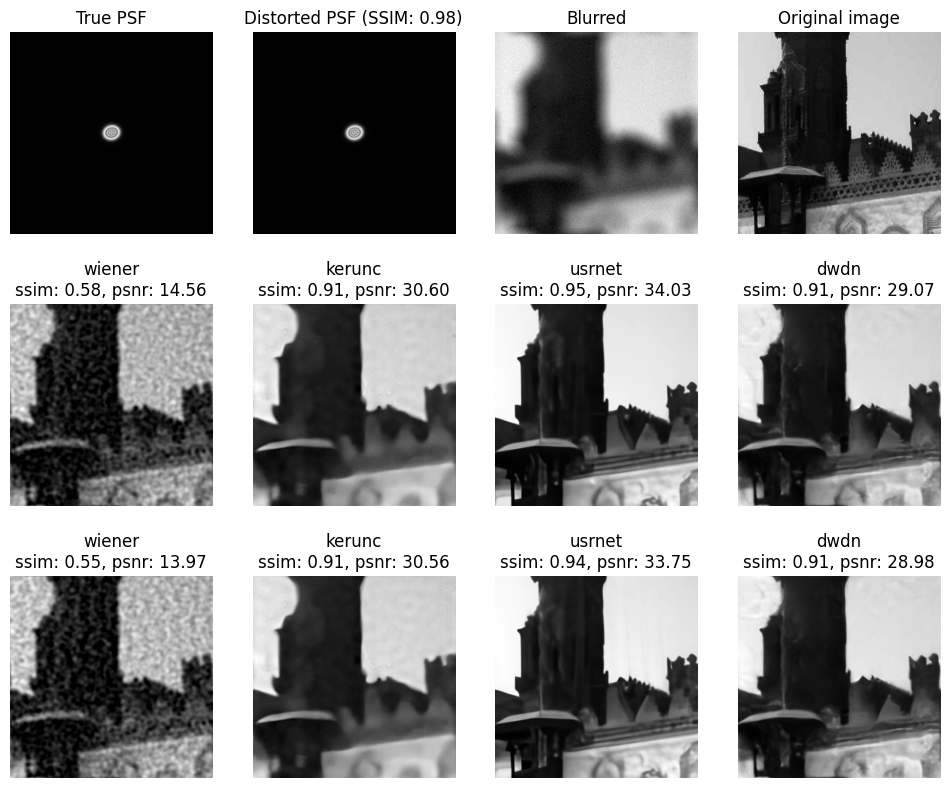

In [11]:
IS_NOISED = True

image, psf, blurred, blurred_3d = get_image_psf(
    image_path='../datasets/gt/Sun-gray/im_48.png',
    psf_path='../datasets/kernels/eye-psf/processed/synthetic/small-psf-0.npy',
    is_noised=IS_NOISED,
    crop=True,
)

psf_distorted = distorter('eye', psf=psf, delta_size=-6)

viz(image, psf, psf_distorted, blurred, blurred_3d, models, is_noised=IS_NOISED)

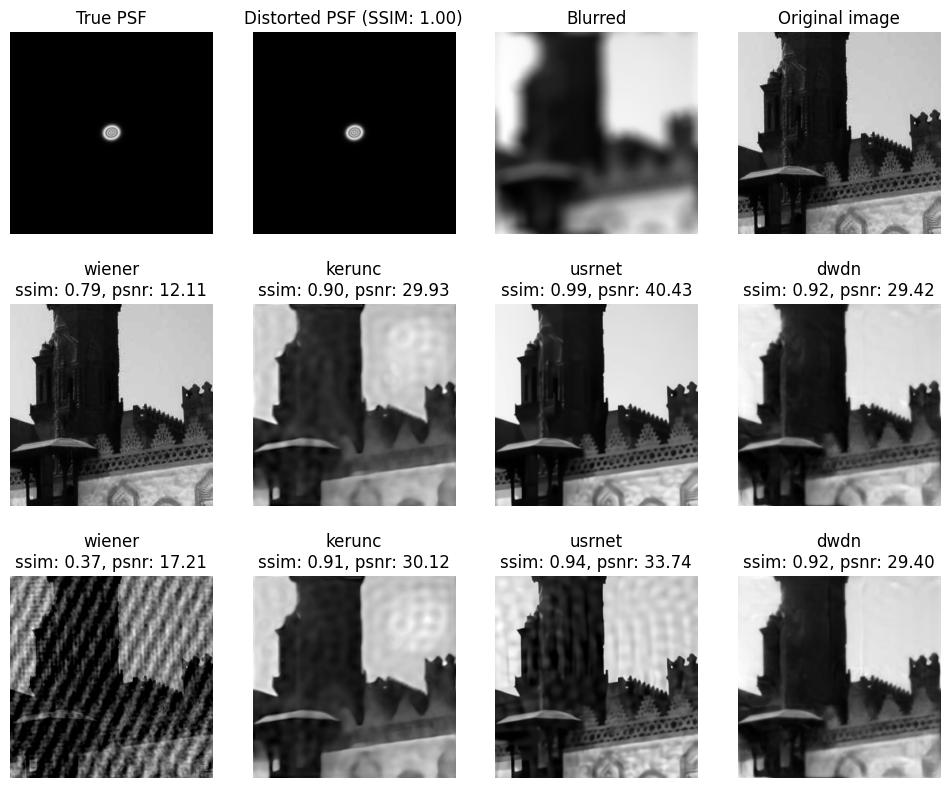

In [12]:
IS_NOISED = False

image, psf, blurred, blurred_3d = get_image_psf(
    image_path='../datasets/gt/Sun-gray/im_48.png',
    psf_path='../datasets/kernels/eye-psf/processed/synthetic/small-psf-0.npy',
    is_noised=IS_NOISED,
    crop=True,
)

psf_distorted = distorter('eye', psf=psf, delta_size=-6)

viz(image, psf, psf_distorted, blurred, blurred_3d, models, is_noised=IS_NOISED)

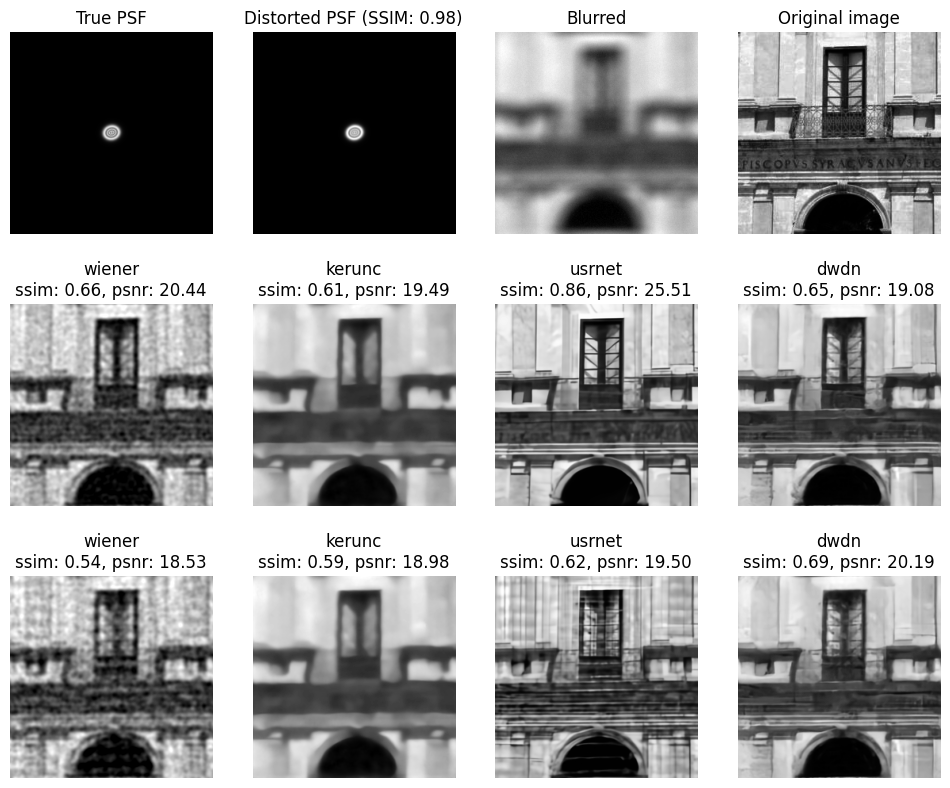

In [13]:
IS_NOISED = True

image, psf, blurred, blurred_3d = get_image_psf(
    image_path='../datasets/gt/Sun-gray/im_10.png',
    psf_path='../datasets/kernels/eye-psf/processed/synthetic/small-psf-0.npy',
    is_noised=IS_NOISED,
    crop=True,
)

psf_distorted = distorter('eye', psf=psf, delta_size=-15)

viz(image, psf, psf_distorted, blurred, blurred_3d, models, is_noised=IS_NOISED)